## Machine learning analysis 8,959 potentially-informative features derived from molecular modeling* for thier use in prediciting experimental $k_{cat}$, $K_M$, and $k_{cat}/K_M$

### *stock enzyme design protocol

We are interested in using machine learning tools to predict enzyme function from protein structure. In order to put this in machine learning tools, we need to identify informative features from the molecular modeling feature set $F$. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
from sklearn import preprocessing, linear_model, ensemble, feature_selection, model_selection, pipeline 

In [3]:
import pandas 
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [4]:
! pwd

/Users/alex/Documents/bglb_family/machine_learning


## Features! 

In [5]:
! rsync -avz ca:/share/work/alex/stock_enzyme_design_protocol/data.h5 data2.h5 

/home/carlin/.bashrc: line 3: bind: warning: line editing not enabled
receiving file list ... done

sent 16 bytes  received 88 bytes  29.71 bytes/sec
total size is 14344384  speedup is 137926.77


In [6]:
feat = pandas.read_hdf('data2.h5')
feat.head()

0                                                         \
         label fa_atr fa_rep  fa_sol fa_intra_rep fa_elec pro_close   
A192S  weights    1.0   0.55  0.9375        0.005   0.875      1.25   
A306N  weights    1.0   0.55  0.9375        0.005   0.875      1.25   
A356A  weights    1.0   0.55  0.9375        0.005   0.875      1.25   
A357A  weights    1.0   0.55  0.9375        0.005   0.875      1.25   
E177K  weights    1.0   0.55  0.9375        0.005   0.875      1.25   

                                                 ...             447  \
      hbond_sr_bb hbond_lr_bb hbond_bb_sc        ...        hbond_sc   
A192S        1.17        1.17        1.17        ...        -3.03171   
A306N        1.17        1.17        1.17        ...        -3.18737   
A356A        1.17        1.17        1.17        ...        -3.35449   
A357A        1.17        1.17        1.17        ...        -3.33426   
E177K        1.17        1.17        1.17        ...        -3.36620   

                                                                       \
      dslf_fa13 rama omega fa_dun p_aa_pp yhh_planarity  ref    total   
A192S       0.0  0.0   0.0    0.0     0.0           0.0  0.0 -3.89029   
A306N       0.0  0.0   0.0    0.0     0.0           0.0  0.0 -4.42077   
A356A       0.0  0.0   0.0    0.0     0.0           0.0  0.0 -4.26879   
A357A       0.0  0.0   0.0    0.0     0.0           0.0  0.0 -4.19985   
E177K       0.0  0.0   0.0    0.0     0.0           0.0  0.0 -4.37823   

                         
      sequence_position  
A192S               446  
A306N               446  
A356A               446  
A357A               446  
E177K               446  

[5 rows x 8959 columns]

In [7]:
feat.shape

(182, 8959)

Before we get in to the targets, let's get rid of as many of these features as we can. Having 12,991 features for only 200 samples is not great!

First, let's get rid of string features, since they are likely labels. Easiest way to do this is to get all the features that are float64. 

In [8]:
feat = feat.select_dtypes(['float64'])
feat.shape

(182, 8063)

And, let's get rid of features with 0 variance. 

In [9]:
zero_variance_features = []
for col in feat.columns:
    if feat[col].std() == 0.0:
        zero_variance_features.append(col)
feat = feat.drop(zero_variance_features, axis=1)
feat.shape

(182, 5023)

Ooooh, that is good, we get rid of another 3,694 useless features this way! 

Now that we have a "reasonable" set of features. Let's try looking at the targets. 

In [10]:
# ligand only features! 
feat = feat[447]
feat.shape

(182, 7)

## Machine learning targets! 

In [11]:
targets = pandas.read_csv('/Users/alex/Documents/bglb_data_set/bglb_targets.csv', index_col=0)

# remove a funky data point 
targets = targets.drop('F415A', axis=0)

targets.head()

,kcat,km,kcatkm
mutant_name,,,
S14A,2.505150,0.916454,4.589089
T15A,2.788168,0.724276,5.063892
S16A,2.187521,1.146438,4.041274
S17A,2.928396,1.265996,4.662550
S17E,2.806858,0.864511,4.942484


In [12]:
targets.shape

(110, 3)

Now, let's see if we can join these and get something out 

In [13]:
J = feat.join(targets)
J.head()

,fa_atr,fa_rep,fa_sol,fa_intra_rep,fa_elec,hbond_sc,total,kcat,km,kcatkm
A192S,-11.8267,1.33128,13.3406,0.03927,-3.74311,-3.03171,-3.89029,2.975891,0.706718,5.269158
A306N,-11.8133,1.23626,13.2531,0.03910,-3.94859,-3.18737,-4.42077,NaN,NaN,NaN
A356A,-11.8475,1.33786,13.2661,0.03930,-3.71004,-3.35449,-4.26879,NaN,NaN,NaN
A357A,-11.8786,1.39338,13.2893,0.03931,-3.70902,-3.33426,-4.19985,NaN,NaN,NaN
E177K,-11.8111,1.34083,13.2388,0.03913,-3.81969,-3.36620,-4.37823,2.744293,0.791691,4.952352


OK, that'll work! Now, let's make a nice dict where we can do each of kcat, km, and kcat/KM at the same time! 

In [14]:
J.query('fa_sol<12.6')

,fa_atr,fa_rep,fa_sol,fa_intra_rep,fa_elec,hbond_sc,total,kcat,km,kcatkm
F415A,-11.0202,1.20163,12.0939,0.05087,-3.40713,-3.12900,-4.20988,NaN,NaN,NaN
H119E,-11.1390,1.30614,12.2895,0.05183,-3.50564,-3.21921,-4.21645,NaN,NaN,NaN


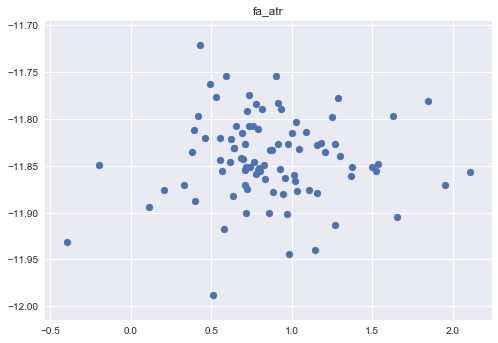

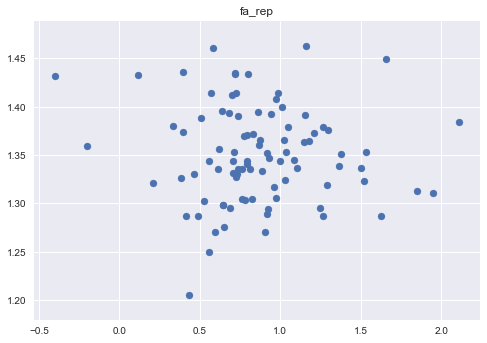

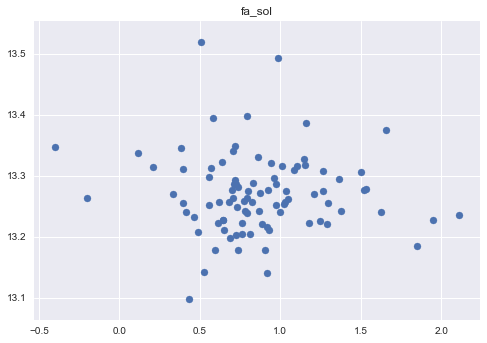

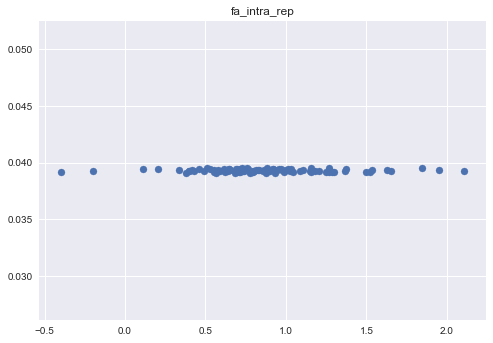

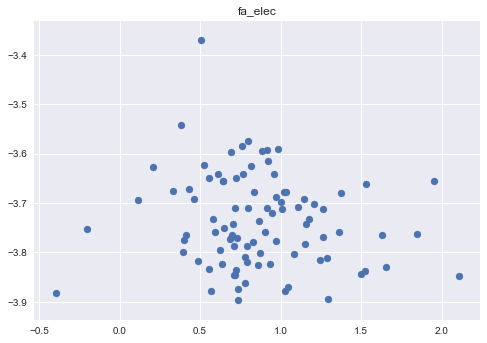

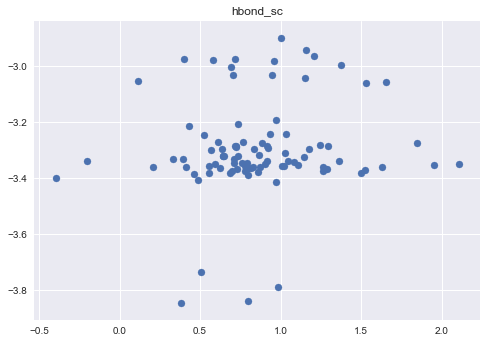

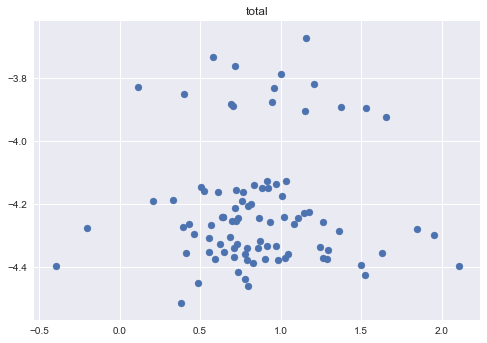

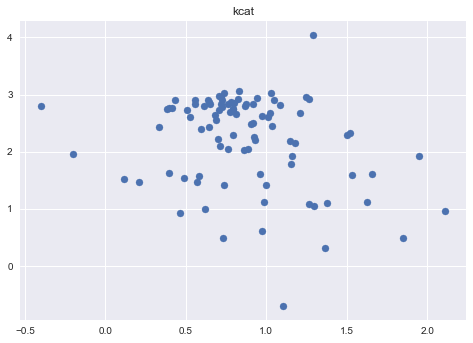

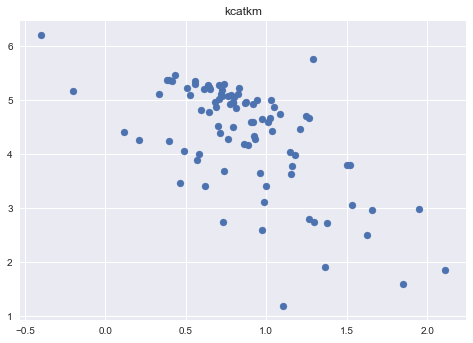

In [15]:
for col in J:
    if col != 'km':
        plt.scatter(J.km, J[col])
        plt.subplot()
        plt.title(col)
        plt.show()

In [16]:
d = J.drop(['kcat', 'kcatkm'], axis=1).dropna()
d.shape

(91, 8)

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import decomposition, manifold

X = d.drop('km', axis=1)
y = d.km.ravel()

X.shape, y.shape 

((91, 7), (91,))

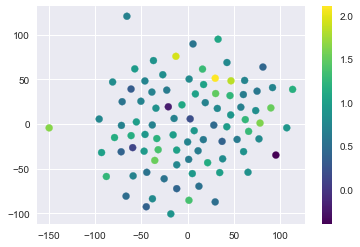

In [18]:
tsne = manifold.TSNE()
X_ = tsne.fit_transform(X)
plt.scatter(*X_.T, c=y, cmap='viridis')
plt.colorbar()

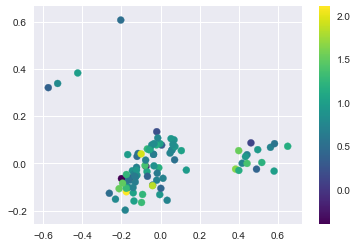

In [19]:
pca = decomposition.PCA(n_components=2)
X_ = pca.fit_transform(X)
plt.scatter(X_[:,0], X_[:,1], c=y, cmap='viridis')
plt.colorbar()

In [20]:
# opts = dict(plot_width=600, plot_height=400, min_border=0)
# p1 = figure(**opts)
# r1 = p1.circle([1,2,3], [4,5,6], size=20)

# p2 = figure(**opts)
# r2 = p2.circle([1,2,3], [4,5,6], size=20)

# # get a handle to update the shown cell with
# t = show(row(p1, p2), notebook_handle=True)

In [21]:
tgts = 'kcat km kcatkm'.split()

In [22]:
runs = []
for tgt in tgts:
    X = J.ix[:,0:-3]
    y = J[tgt]
    G = X.join(y).dropna()
    
    d = G.corr()[[tgt]]
    d['abs'] = d[tgt].map(abs)
    d = d.sort_values('abs', ascending=False).head(11).drop(tgt)
    print(d)
    
    print('select a, resi ', end='')

    for idx, ddf in d.iterrows():
        print(idx[0],end='')
        print('+',end='')
    
    print('446')
    
    X = G.ix[:,0:-1]
    y = G.ix[:,-1].ravel()
    pkg = tgt, X, y 
    runs.append(pkg)
    print(tgt, X.shape, y.shape)

                  kcat       abs
fa_intra_rep -0.138975  0.138975
fa_sol       -0.095546  0.095546
fa_atr        0.094162  0.094162
fa_rep       -0.061218  0.061218
total        -0.055970  0.055970
hbond_sc     -0.042222  0.042222
fa_elec       0.016878  0.016878
select a, resi f+f+f+f+t+h+f+446
kcat (101, 7) (101,)
                    km       abs
fa_elec      -0.130914  0.130914
hbond_sc      0.122086  0.122086
fa_sol       -0.035619  0.035619
fa_rep       -0.033002  0.033002
total         0.026143  0.026143
fa_atr        0.018558  0.018558
fa_intra_rep  0.003952  0.003952
select a, resi f+h+f+f+t+f+f+446
km (101, 7) (101,)
                kcatkm       abs
fa_intra_rep -0.113015  0.113015
hbond_sc     -0.082923  0.082923
fa_atr        0.067013  0.067013
fa_elec       0.066743  0.066743
fa_sol       -0.061225  0.061225
total        -0.054659  0.054659
fa_rep       -0.034680  0.034680
select a, resi f+h+f+f+f+t+f+446
kcatkm (101, 7) (101,)


In [23]:
pts = []
results = []
for tgt, X, y in runs:
    print(tgt, X.shape, y.shape) 
    
    pln = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('clf', linear_model.ElasticNetCV(cv=10, n_alphas=1000, eps=0.01, l1_ratio=[.5,.9,.99], max_iter=1e9, n_jobs=-1, normalize=True)),
    ])
    
    preds = model_selection.cross_val_predict(pln, X, y, cv=10)
    
    opts = dict(plot_width=300, plot_height=300)
    plot = figure(**opts)
    plot.circle(y, preds)
    pts.append(plot)
    
show(row(pts), notebook_handle=True)    

kcat (101, 7) (101,)
km (101, 7) (101,)
kcatkm (101, 7) (101,)


In [24]:
pts = []
results = []
for tgt, X, y in runs:
    
    print(tgt, X.shape, y.shape) 
    
    pln = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('clf', linear_model.ElasticNetCV(cv=5, l1_ratio=0.9, max_iter=1e9)),
    ])
    
    pln.fit(X, y)
    preds = pln.predict(X)
    
    opts = dict(plot_width=300, plot_height=300)
    plot = figure(**opts)
    plot.circle(y, preds)
    pts.append(plot)
    
show(row(pts), notebook_handle=True)    

kcat (101, 7) (101,)
km (101, 7) (101,)
kcatkm (101, 7) (101,)


In [25]:
_, en = pln.steps[1]
en.coef_.shape

(7,)

(0, 9)

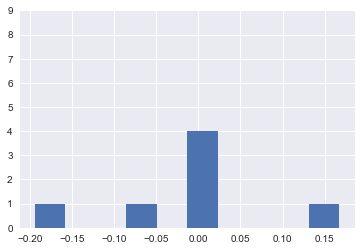

In [26]:
plt.hist(en.coef_)
plt.ylim(0,9)

In [28]:
list(zip(X.columns, en.coef_))

[('fa_atr', 0.0),
 ('fa_rep', 0.0),
 ('fa_sol', -0.061783387604673272),
 ('fa_intra_rep', -0.19401018150117397),
 ('fa_elec', 0.16747135902344767),
 ('hbond_sc', -0.0),
 ('total', -0.0)]